# Step 1: Install required packages

In [3]:
!pip install insightface opencv-python matplotlib
!pip install onnxruntime

print("Packages installed successfully!")

Packages installed successfully!


# Step 2: Import all necessary libraries

In [4]:
import cv2
import numpy as np
from insightface.app import FaceAnalysis
from insightface.model_zoo import get_model
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

print("All libraries imported successfully!")


All libraries imported successfully!


# Step 3: Initialize Models


In [32]:
print("Loading face analysis model...")
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640))

print("Loading face swapper model...")
swapper = get_model('weights/inswapper_128.onnx', download=False, download_zip=False)

print("Models loaded successfully!")


Loading face analysis model...
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/prem/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/prem/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/prem/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/prem/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0


/home/prem/Boonsai/face_swap_video/venv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/prem/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Loading face swapper model...
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
inswapper-shape: [1, 3, 128, 128]
Models loaded successfully!


# Step 4: Take video input from user

In [36]:
input_video_path = input("Enter the path to your input video: ").strip().strip('"')

# Validate input file
if not Path(input_video_path).exists():
    print(f"Error: Input video '{input_video_path}' not found.")
else:
    print(f"Video found: {input_video_path}")

Video found: data/input__.mp4


In [37]:
import ffmpeg

output_filename = os.path.splitext(input_video_path)[0] + ".mp3"
ffmpeg.input(input_video_path).output(output_filename, acodec='mp3').run()
print(f"Audio extracted successfully to: {output_filename}")


Audio extracted successfully to: data/input__.mp3


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

# Step 5: Detect and displaying all unique faces in the video

Scanning video for all faces...
Clustering faces...
Clustering complete! Found 1 unique persons.


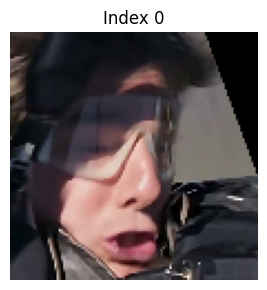

--- Unique Persons Found ---
Index 0: Representative face at [x1:451, y1:647, x2:942, y2:1340]
Index -1: Swap ALL persons


In [38]:
# Step 5: Detect all unique faces in the video
from sklearn.cluster import DBSCAN
from insightface.utils import face_align

print("Scanning video for all faces...")

cap = cv2.VideoCapture(input_video_path)  # <-- use variable, not string
all_faces = []
all_embeddings = []
frame_count = 0
sampling_interval = 10

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % sampling_interval != 0: # it takes every 10th frame in the entire video eg: 0th frame, 10th frame, 20th frame, 30th frame etc...
        frame_count += 1
        continue

    detected_faces = app.get(frame)
    '''
    detected_faces = [
    {
        'bbox': [10, 20, 100, 100],
        'landmarks': [(30, 40), (50, 60), (70, 80)],
        'embedding': [0.1, 0.2, 0.3, ...],
        'confidence': 0.8
    },
    {
        'bbox': [150, 200, 250, 250],
        'landmarks': [(180, 220), (200, 240), (220, 260)],
        'embedding': [0.4, 0.5, 0.6, ...],
        'confidence': 0.9
    }
]
    '''

    for face in detected_faces:
        face['frame_idx'] = frame_count  # save frame index for later retrieval
        all_faces.append(face)
        all_embeddings.append(face['embedding'])

    frame_count += 1
    if frame_count % 50 == 0:
        clear_output(wait=True)
        print(f"Scanned {frame_count} frames, collected {len(all_faces)} faces...")

cap.release()

# Convert embeddings to numpy safely
if len(all_embeddings) == 0:
    print("No faces detected in the entire video. Exiting.")
else:
    all_embeddings = np.array(all_embeddings)

    if all_embeddings.ndim == 1:
        all_embeddings = all_embeddings.reshape(1, -1)  # ensure 2D

    print("Clustering faces...")
    clustering = DBSCAN(eps=0.6, min_samples=3, metric="cosine").fit(all_embeddings)
    labels = clustering.labels_

    '''
    DBSCAN groups similar faces into clusters.

        eps=0.6: max allowed distance between embeddings to be in same cluster.
        min_samples=3: cluster must have at least 3 similar faces.
        metric="cosine": similarity measure used.
        labels: array of cluster IDs for each face.
        Example: labels = [0, 0, 1, 1, 1, -1, 2, 2, 2, ...]
        -1 = outlier face (not assigned to any cluster).
    '''

    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Clustering complete! Found {num_clusters} unique persons.")

    # Group faces by cluster
    clusters = {}
    for idx, label in enumerate(labels):
        if label == -1:
            continue
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(all_faces[idx])

    '''
    Builds dictionary:

        clusters = {
            0: [face_1, face_2, face_3, ...],
            1: [face_4, face_5, ...],
            2: [face_7, face_8, ...]
        }

    Outliers (-1) ignored.
    '''

    # Step 6: Display the unique faces with their indices
    if len(clusters) == 0:
        print("No valid clusters found. Exiting.")
    else:
        cluster_reps = []
        for label, faces in clusters.items():
            best_face = max(
                faces,
                key=lambda f: (f['bbox'][2] - f['bbox'][0]) * (f['bbox'][3] - f['bbox'][1])
            )
            cluster_reps.append((label, best_face))

        num_faces = len(cluster_reps)
        cols = min(5, num_faces)
        rows = (num_faces + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

        if num_faces == 1:
            axes = np.array([[axes]])
        elif rows == 1:
            axes = axes.reshape(1, -1)

        for i in range(rows * cols):
            row = i // cols
            col = i % cols

            if i < num_faces:
                label, face = cluster_reps[i]
                frame_idx = face['frame_idx']

                cap = cv2.VideoCapture(input_video_path)
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()
                cap.release()

                if ret:
                    aligned_face = face_align.norm_crop(frame, landmark=face['kps'])
                    axes[row, col].imshow(cv2.cvtColor(aligned_face, cv2.COLOR_BGR2RGB))

                axes[row, col].set_title(f"Index {label}", fontsize=12)
                axes[row, col].axis('off')
            else:
                axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

        print("--- Unique Persons Found ---")
        for label, face in cluster_reps:
            bbox = face['bbox'].astype(int)
            print(f"Index {label}: Representative face at "
                  f"[x1:{bbox[0]}, y1:{bbox[1]}, x2:{bbox[2]}, y2:{bbox[3]}]")
        print("Index -1: Swap ALL persons")


# Step 7: Take source image from user

Source face loaded successfully!


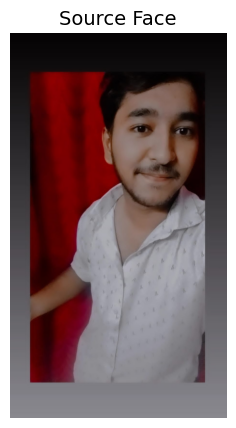

In [39]:
source_image_path = input("Enter the path to your source image: ").strip().strip('"')

# Validate source image
if not Path(source_image_path).exists():
    print(f"Error: Source image '{source_image_path}' not found.")
else:
    source_img = cv2.imread(source_image_path)
    source_faces = app.get(source_img)
    
    if len(source_faces) == 0:
        print("No face found in the source image. Exiting.")
    else:
        source_face = source_faces[0]
        print("Source face loaded successfully!")
        
        # Display source face
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB))
        plt.title("Source Face", fontsize=14)
        plt.axis('off')
        plt.show()

# Step 8: Ask user to choose which face to swap

In [40]:
try:
    chosen_index = int(input(f"Enter the index of the person to swap (0 to {len(clusters)-1}, or -1 for all): "))
    
    if chosen_index < -1 or chosen_index >= len(clusters):
        print("Invalid index. Exiting.")
    else:
        target_description = "ALL persons" if chosen_index == -1 else f"person at index {chosen_index}"
        print(f"Will swap {target_description} with the source face.")
        
except ValueError:
    print("Invalid input. Please enter a number.")


Will swap person at index 0 with the source face.


# Step 9: Process the video and perform the face swap


In [41]:
print("Starting video processing...")

cap = cv2.VideoCapture(input_video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create output file
output_video_path = f"swapped_{Path(input_video_path).stem}.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

processed_frames = 0

# Precompute target embeddings if a specific person is chosen
if chosen_index != -1:
    target_embeddings = [f['embedding'] for f in clusters[chosen_index]]

while True:
    ret, frame = cap.read()
    if not ret:
        break

    detected_faces = app.get(frame)

    if detected_faces:
        for face in detected_faces:
            if chosen_index == -1:
                # Swap ALL persons
                frame = swapper.get(frame, face, source_face, paste_back=True)
            else:
                # Check if this detected face belongs to the chosen cluster
                new_embedding = face['embedding']
                sims = [
                    np.dot(new_embedding, t) / 
                    (np.linalg.norm(new_embedding) * np.linalg.norm(t))
                    for t in target_embeddings
                ]
                if max(sims) > 0.65:  # similarity threshold
                    frame = swapper.get(frame, face, source_face, paste_back=True)

    out.write(frame)
    processed_frames += 1

    if processed_frames % 10 == 0:
        clear_output(wait=True)
        progress_percent = (processed_frames / frame_count) * 100
        print(f"Processed {processed_frames}/{frame_count} frames ({progress_percent:.1f}%)")

cap.release()
out.release()
clear_output(wait=True)

print("PROCESSING COMPLETE!")
print("----------------------------")
print(f"Input video: {Path(input_video_path).name}")
print(f"Output video: {output_video_path}")
print(f"Faces swapped: {'ALL' if chosen_index == -1 else f'Person {chosen_index}'}")
print(f"Total frames processed: {processed_frames}")
print("----------------------------")


PROCESSING COMPLETE!
----------------------------
Input video: input__.mp4
Output video: swapped_input__.mp4
Faces swapped: Person 0
Total frames processed: 431
----------------------------


In [42]:
video_path = output_video_path
audio_path = "/home/prem/Boonsai/face_swap_video/data/input__.mp3"

try:
    input_video = ffmpeg.input(video_path)
    input_audio = ffmpeg.input(audio_path)

    output_filename = os.path.splitext(video_path)[0] + "_with_new_audio.mp4"

    ffmpeg.concat(input_video, input_audio, v=1, a=1).output(output_filename).run()

    print(f"Video with new audio created successfully at: {output_filename}")
except ffmpeg.Error as e:
    print(f"Error adding audio to video: {e.stderr.decode()}")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video with new audio created successfully at: swapped_input___with_new_audio.mp4


frame=  431 fps=137 q=-1.0 Lsize=   11875kB time=00:00:18.60 bitrate=5227.9kbits/s speed=5.92x    
video:11577kB audio:286kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.101966%
[aac @ 0x6509f4168440] Qavg: 456.688
[libx264 @ 0x6509f4177940] frame I:12    Avg QP:16.65  size: 39689
[libx264 @ 0x6509f4177940] frame P:311   Avg QP:20.94  size: 29945
[libx264 @ 0x6509f4177940] frame B:108   Avg QP:22.99  size: 19124
[libx264 @ 0x6509f4177940] consecutive B-frames: 61.5% 11.6% 11.1% 15.8%
[libx264 @ 0x6509f4177940] mb I  I16..4: 36.5% 61.8%  1.7%
[libx264 @ 0x6509f4177940] mb P  I16..4: 14.4% 38.6%  0.9%  P16..4: 19.6%  4.5%  2.1%  0.0%  0.0%    skip:19.8%
[libx264 @ 0x6509f4177940] mb B  I16..4:  5.4% 11.1%  0.7%  B16..8: 32.6%  5.1%  0.9%  direct: 3.8%  skip:40.3%  L0:54.0% L1:39.7% BI: 6.3%
[libx264 @ 0x6509f4177940] 8x8 transform intra:70.2% inter:83.3%
[libx264 @ 0x6509f4177940] coded y,uvDC,uvAC intra: 27.1% 43.3% 3.6% inter: 15.6% 16.6% 0.4%
[libx264 @ 0x6509f